# Physics-informed neural network (PINN) demo


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ \frac{d^2y}{dx^2} - 400*y = 0 $$

$$ y(0) = 300 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(x):
    u = ((np.cos(1-x)+2*np.cos(x))/np.sin(1)) + x**2 -2
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

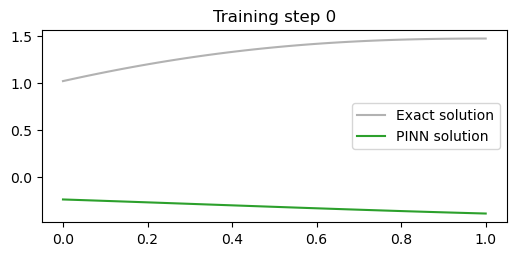

Epoch [1/6000], Loss: 1.6568
BC1 LOSS 1.3429088592529297
BC2 LOSS 0.01605793461203575
PDE LOSS 0.4854627549648285


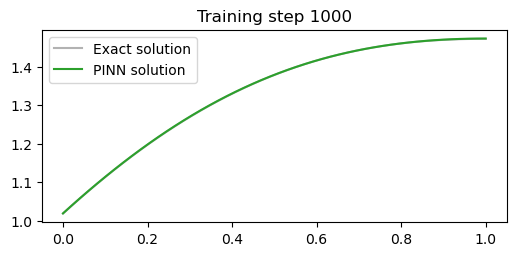

Epoch [1001/6000], Loss: 0.0005
BC1 LOSS 1.5948131704135449e-09
BC2 LOSS 7.821667935559162e-08
PDE LOSS 0.0005173086537979543


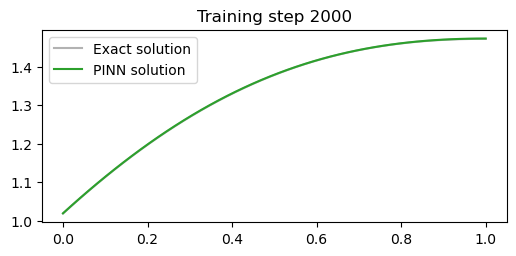

Epoch [2001/6000], Loss: 0.0002
BC1 LOSS 1.776248836904415e-08
BC2 LOSS 1.4355971700297232e-07
PDE LOSS 0.00022219771926756948


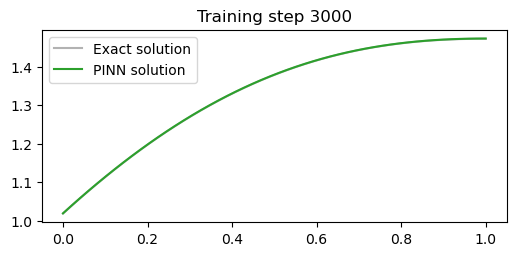

Epoch [3001/6000], Loss: 0.0000
BC1 LOSS 2.122084197253571e-08
BC2 LOSS 8.340993673527919e-08
PDE LOSS 3.061148163396865e-05


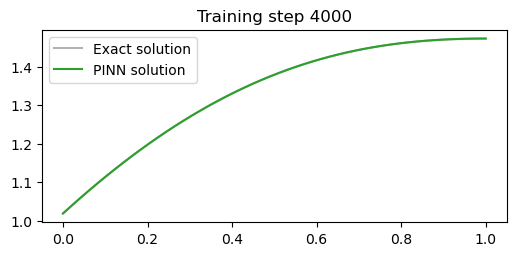

Epoch [4001/6000], Loss: 0.0000
BC1 LOSS 4.53646009646036e-09
BC2 LOSS 6.667632224122144e-09
PDE LOSS 9.477343155595008e-06


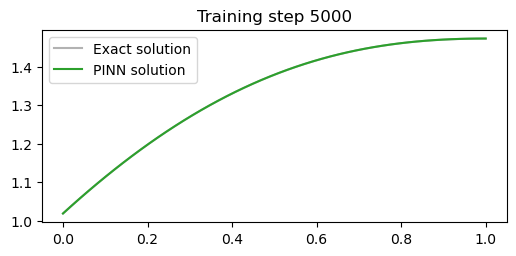

Epoch [5001/6000], Loss: 0.0000
BC1 LOSS 2.9939570822534733e-09
BC2 LOSS 3.365563827628648e-09
PDE LOSS 8.19407887320267e-06


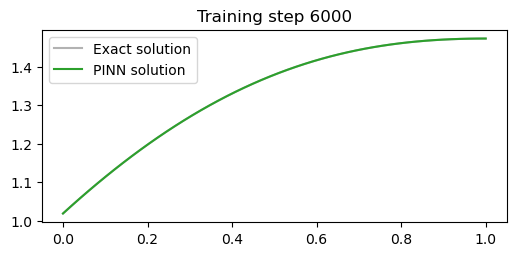

Epoch [6001/6000], Loss: 0.0000
BC1 LOSS 2.1173605091462377e-09
BC2 LOSS 2.362018580726044e-09
PDE LOSS 6.7170772126701195e-06


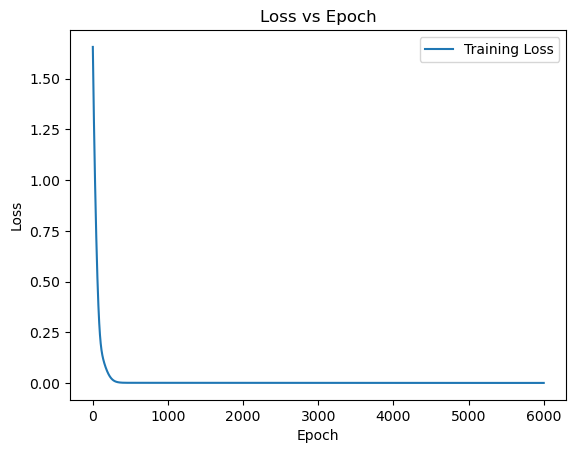

In [3]:
# define a neural network to train
pinn = FCN(1, 1, 64,3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary2 = torch.tensor(1.0).view(-1,1).requires_grad_(True)# (1, 1)
# x_boundary3 = torch.tensor(3.0).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 1,200).view(-1,1).requires_grad_(True)# (20, 1)

x_test = torch.linspace(0,1,50).view(-1,1) #(200, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 6000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.9, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    dudx = torch.autograd.grad(u, x_boundary, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss1 = torch.mean((dudx-1)**2)

    u2 = pinn(x_boundary2)
    dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss2 = torch.mean((dudx)**2)

    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss3 = torch.mean((dudx2 + u -x_physics**2)**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

Avg Percentage Error (excluding infinite values) is: 0.008623010516166686
Maximum Percentage Error (excluding infinite values) is: [0.010834197513759136]


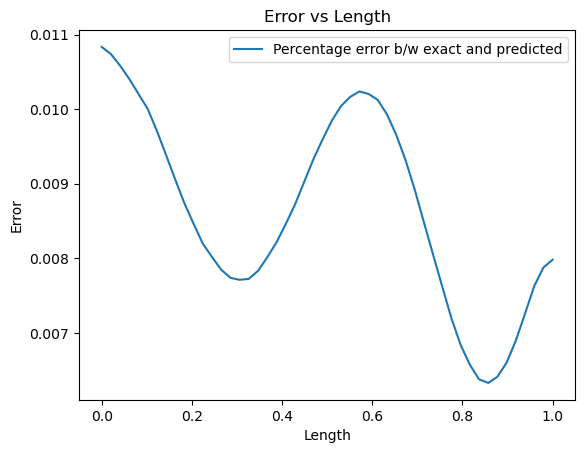

In [4]:
# Calculate error
diff = abs(u_exact - u) / abs(0.01 * u_exact)

# Mask out infinite values
masked_diff = np.ma.masked_invalid(diff)
max_error = max(masked_diff)

# Calculate mean excluding infinite values
mean_error = np.mean(masked_diff)

print(f'Avg Percentage Error (excluding infinite values) is: {mean_error}')
print(f'Maximum Percentage Error (excluding infinite values) is: {max_error}')

# Plot
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()


Overall RMSE is: 0.0001148890150943771


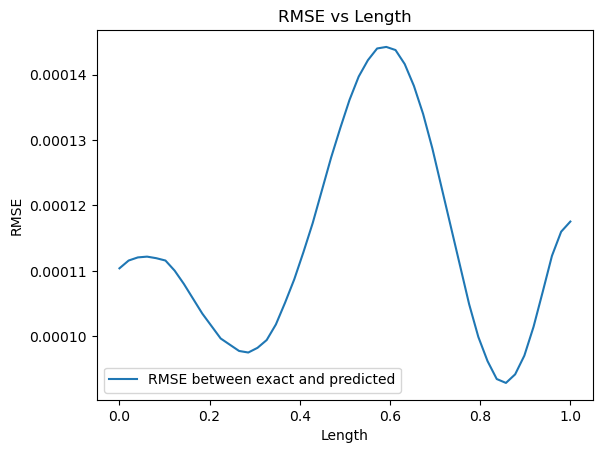

In [5]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()


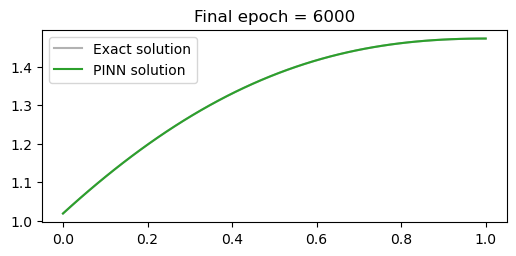

In [6]:
plt.figure(figsize=(6,2.5))
plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
plt.title(f"Final epoch = {i}")
plt.legend()
plt.show()

In [7]:
print(u[-2])
print(u_exact)

tensor([1.4726])
tensor([[1.0189],
        [1.0391],
        [1.0588],
        [1.0782],
        [1.0970],
        [1.1155],
        [1.1334],
        [1.1509],
        [1.1679],
        [1.1845],
        [1.2006],
        [1.2161],
        [1.2312],
        [1.2459],
        [1.2600],
        [1.2736],
        [1.2867],
        [1.2994],
        [1.3116],
        [1.3232],
        [1.3344],
        [1.3451],
        [1.3553],
        [1.3650],
        [1.3743],
        [1.3831],
        [1.3914],
        [1.3992],
        [1.4066],
        [1.4136],
        [1.4201],
        [1.4261],
        [1.4318],
        [1.4370],
        [1.4418],
        [1.4462],
        [1.4503],
        [1.4539],
        [1.4572],
        [1.4601],
        [1.4627],
        [1.4649],
        [1.4668],
        [1.4684],
        [1.4698],
        [1.4708],
        [1.4716],
        [1.4722],
        [1.4725],
        [1.4726]])


In [8]:
print(len(u))
print((masked_diff))

50
[[0.010834197513759136]
 [0.010738363489508629]
 [0.010582976043224335]
 [0.0104043735191226]
 [0.01020363625138998]
 [0.01000307872891426]
 [0.009707839228212833]
 [0.009384192526340485]
 [0.009053478017449379]
 [0.008735773153603077]
 [0.008459975011646748]
 [0.008194712921977043]
 [0.008016752079129219]
 [0.007846172899007797]
 [0.007739298511296511]
 [0.007712616119533777]
 [0.007726490497589111]
 [0.007834755815565586]
 [0.008016619831323624]
 [0.00821619387716055]
 [0.008460025303065777]
 [0.008720675483345985]
 [0.009024395607411861]
 [0.009326858446002007]
 [0.009593677707016468]
 [0.009843059815466404]
 [0.010041279718279839]
 [0.010163846425712109]
 [0.010237538255751133]
 [0.010204104706645012]
 [0.010123806074261665]
 [0.009930280037224293]
 [0.009658039547502995]
 [0.00932430662214756]
 [0.008929399773478508]
 [0.008490024134516716]
 [0.008055487647652626]
 [0.007625340949743986]
 [0.007199162617325783]
 [0.006841864436864853]
 [0.006577170453965664]
 [0.006379935424774